In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
from core import SITE_NAMES, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE

from cli import get_file_paths
import plot
import pipeline

In [4]:
def get_desired_metrics_from_activity_section(actvt_metric, data_params):
    time_ons = []
    c_lengths = []

    high_actvt_metric = pd.DataFrame()
    for i, col_name in enumerate(data_params["dc_tags"]):
        dc_tag = col_name.split('(')[-1].split(')')[0]
        on = int(dc_tag.split('of')[0])
        total = int(dc_tag.split('of')[-1])
        bin_size = int(data_params['bin_size'])
        dc_actvt = actvt_metric[f'{data_params["metric_tag"]} ({col_name})'].copy()
        if i > 0:
            time_ons.append(on)
            c_lengths.append(total)

        recover_ratio = min(total, bin_size) / min(on, bin_size)
        rep_dc_actvt = dc_actvt * recover_ratio
        
        standard_metric = data_params['metric_tag']
        if data_params["metric_tag"]=='num_dets':
            standard_metric = 'call_rate_per_hour'

        if total-on >= bin_size:
            high_actvt_metric[f'{standard_metric} ({col_name})'] = rep_dc_actvt.replace(np.NaN, -1).replace(0, np.NaN).ffill(limit=(min((14*60)-on, total-on)//bin_size)).replace(np.NaN, 0).replace(-1, np.NaN)
        else:
            high_actvt_metric[f'{standard_metric} ({col_name})'] = rep_dc_actvt

    high_actvt_desired_metrics = high_actvt_metric.copy()
    if standard_metric != 'bout_time':
        high_actvt_desired_metrics = high_actvt_desired_metrics * (2 / 1) # #calls per bin * 2 bins per 1 hour to get calls per hour

    exp_dc_metrics = high_actvt_desired_metrics.iloc[:,1:]
    control_dc_metrics = high_actvt_desired_metrics.iloc[:,0]

    metrics = dict()
    metrics['exp_metric'] = exp_dc_metrics
    metrics['control_metric'] = control_dc_metrics
    metrics['cycle_lengths'] = c_lengths

    return metrics

In [5]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

cycle_lengths = reset_24
percent_ons = [1/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
dc_tags

['30of30',
 '2of6',
 '4of12',
 '6of18',
 '8of24',
 '10of30',
 '12of36',
 '16of48',
 '20of60',
 '24of72',
 '30of90',
 '32of96',
 '40of120',
 '48of144',
 '60of180',
 '80of240',
 '96of288',
 '120of360',
 '160of480',
 '240of720']

In [6]:
def plot_metric_over_cycle_lengths(metrics, data_params):
    exp_dc_metric = metrics['exp_metric']
    control_dc_metric = metrics['control_metric'].mean()
    exp_dc_metric_mean = metrics['exp_metric'].mean()
    exp_dc_metric_ste = metrics['exp_metric'].std()/(metrics['exp_metric'].shape[1])    

    c_lengths = metrics['cycle_lengths']
    plot_key = data_params['type_tag']
    if data_params['type_tag']=='':
        plot_key = 'All'
    if data_params['metric_tag']=='bout_time':
        color_key = 'blue'
    if data_params['metric_tag']=='num_dets':
        color_key = 'darkgreen'
    if data_params['metric_tag']=='activity_index':
        color_key = 'red'
    
    plt.figure(figsize=(12, 4))
    plt.rcParams.update({'font.size':14})
    plt.title(f'{data_params["site_tag"]} for {plot_key} from {data_params["start"]} to {data_params["end"]}')
    plt.errorbar(c_lengths, exp_dc_metric_mean, exp_dc_metric_ste, marker='.', color='k')
    for i, time in enumerate(exp_dc_metric.index):
        plt.scatter(c_lengths, exp_dc_metric.iloc[i,:], marker='o', color=color_key, alpha=0.1)
    plt.axhline(control_dc_metric, linestyle='dashed', color='k', linewidth=2, label=f'{data_params["metric_tag"]} observed from Continuous')
    plt.xlabel('Cycle Lengths (min)')
    plt.ylabel(f"{data_params['metric_tag']} per hour")
    plot_log_labels = np.concatenate([c_lengths[:4], c_lengths[4:16:2], c_lengths[16:20:2], c_lengths[20:]]).astype('int')
    plot_lin_labels = np.concatenate([c_lengths[:11:4], c_lengths[11:15:], c_lengths[15::]]).astype('int')
    plt.xlim(0, c_lengths[-1]+30)
    # ymax = exp_dc_metric.max().max()*0.3
    ymax = 8*control_dc_metric
    plt.ylim(-ymax/10, ymax)
    plt.xticks(plot_lin_labels, plot_lin_labels)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.grid(which='both')
    plt.show()

Carp 


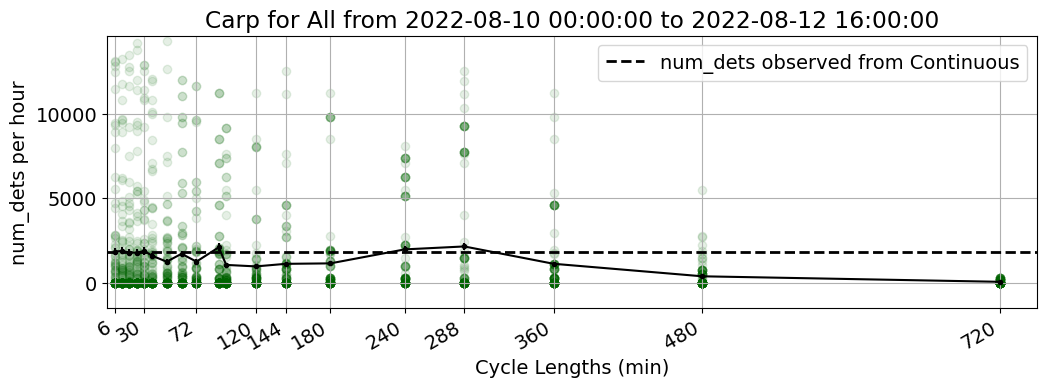

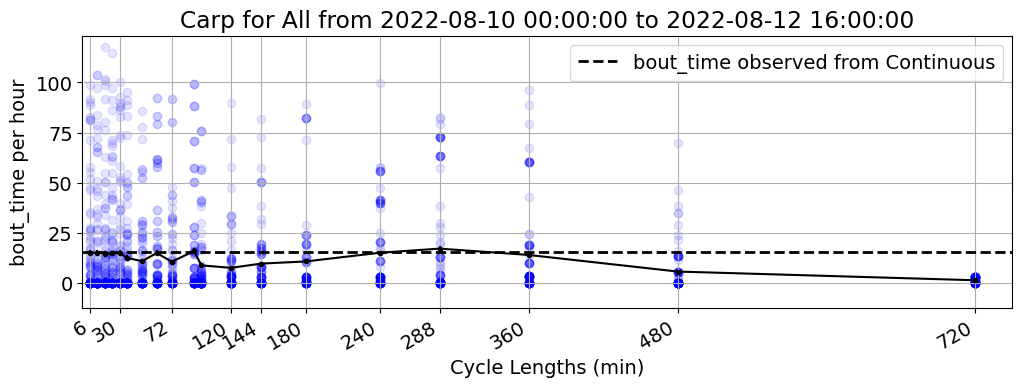

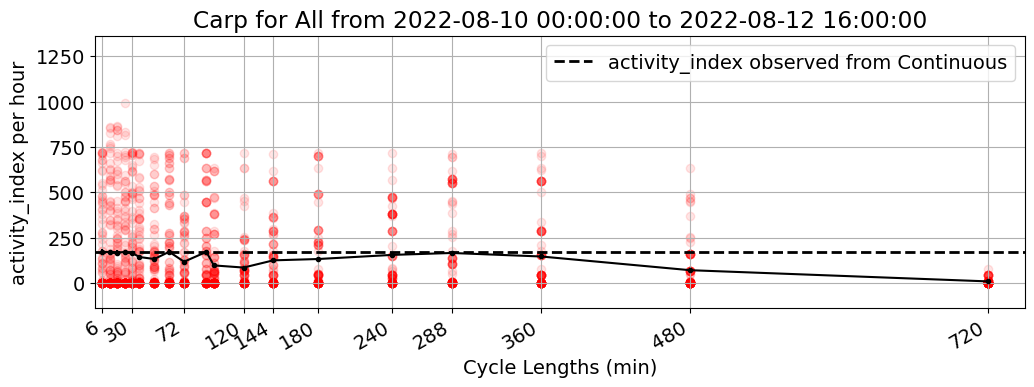

Carp LF


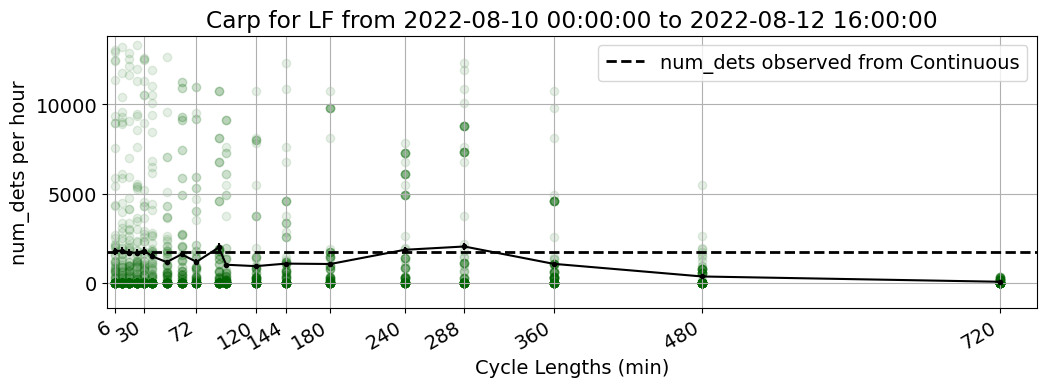

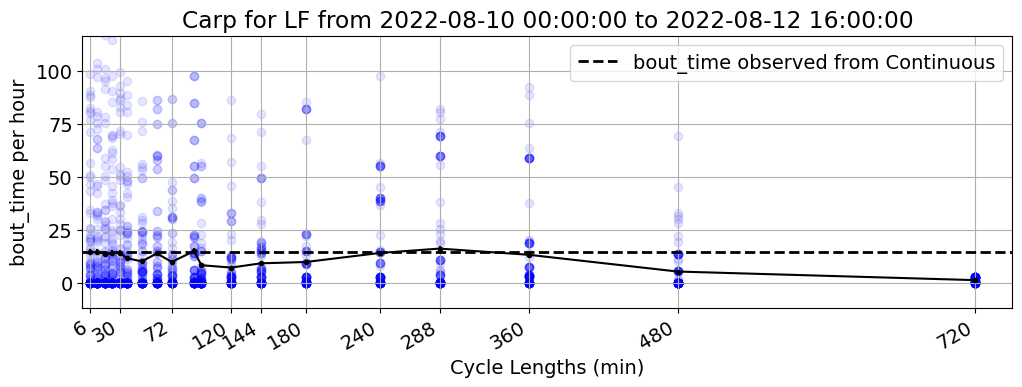

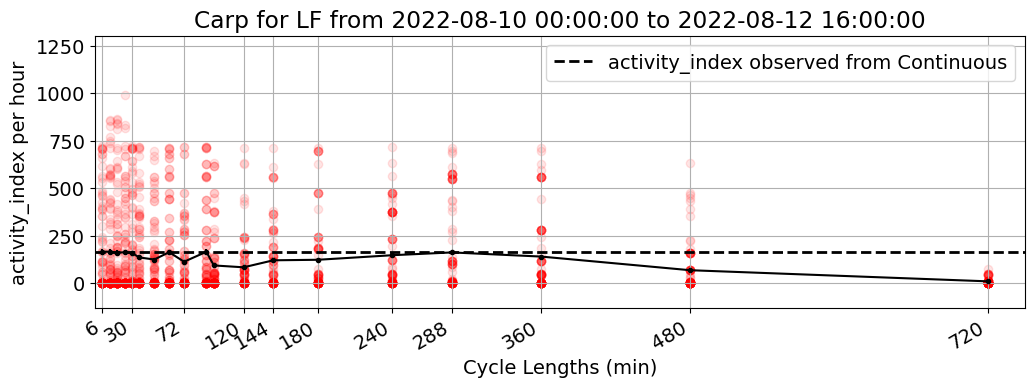

Carp HF


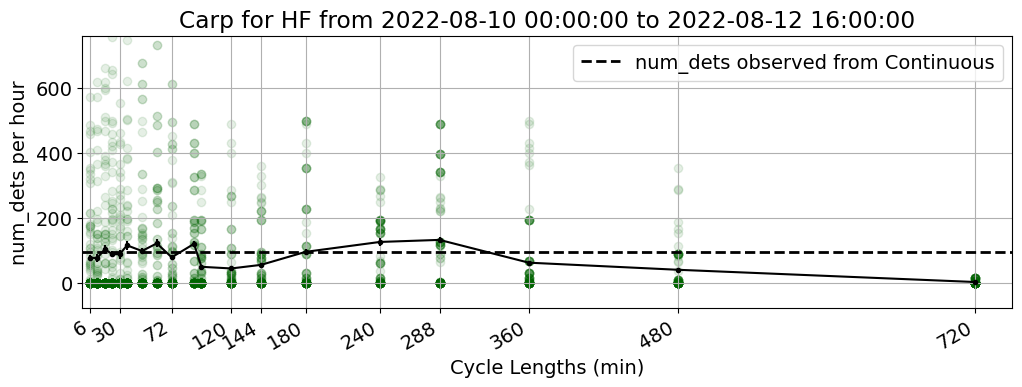

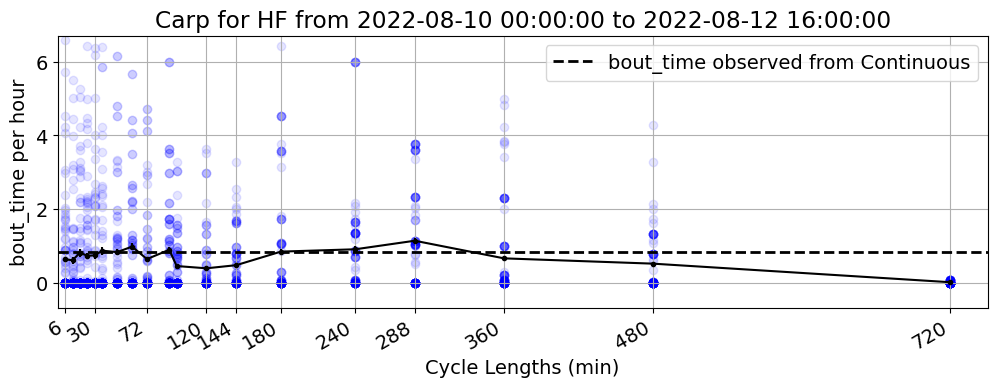

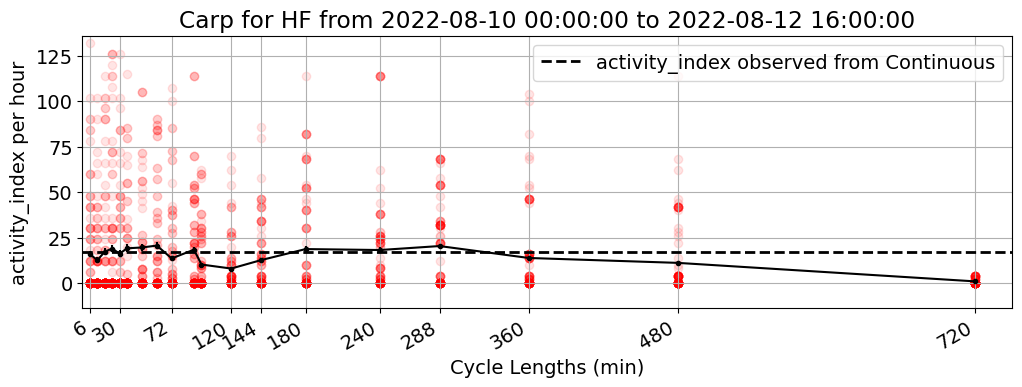

In [7]:
site_key = 'Carp'
type_keys = ['', 'LF', 'HF']
data_params['bin_size'] = '30'
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

for type_key in type_keys:
    print(site_key, type_key)
    data_params["type_tag"] = type_key

    file_paths = get_file_paths(data_params)
    data_params['metric_tag'] = 'num_dets'
    activity_dets_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_dets_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_dets_arr.index = pd.DatetimeIndex(activity_dets_arr.index)
    data_params['start'] = dt.datetime(2022, 8, 10, 0, 0, 0)
    data_params['end'] = dt.datetime(2022, 8, 12, 16, 0, 0)
    actvt_metric = activity_dets_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

    data_params['metric_tag'] = 'bout_time'
    activity_bout_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_bouts_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_bout_arr.index = pd.DatetimeIndex(activity_bout_arr.index)
    actvt_metric = activity_bout_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

    data_params['metric_tag'] = 'activity_index'
    activity_inds_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_inds_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_inds_arr.index = pd.DatetimeIndex(activity_inds_arr.index)
    actvt_metric = activity_inds_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

Carp 


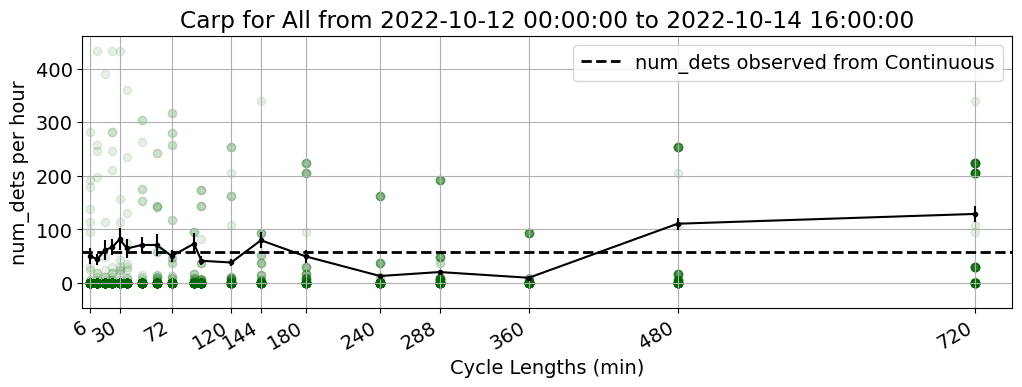

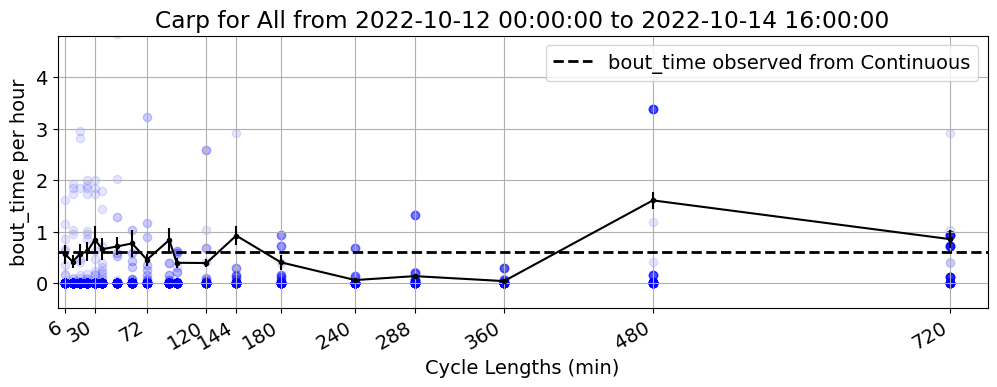

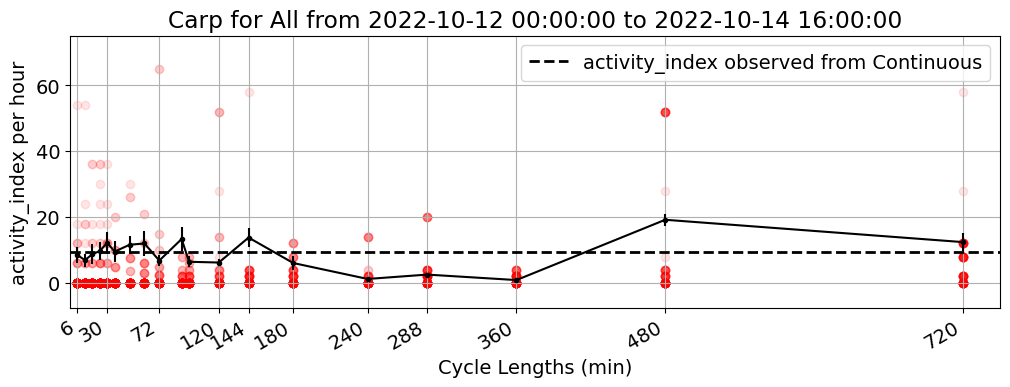

Carp LF


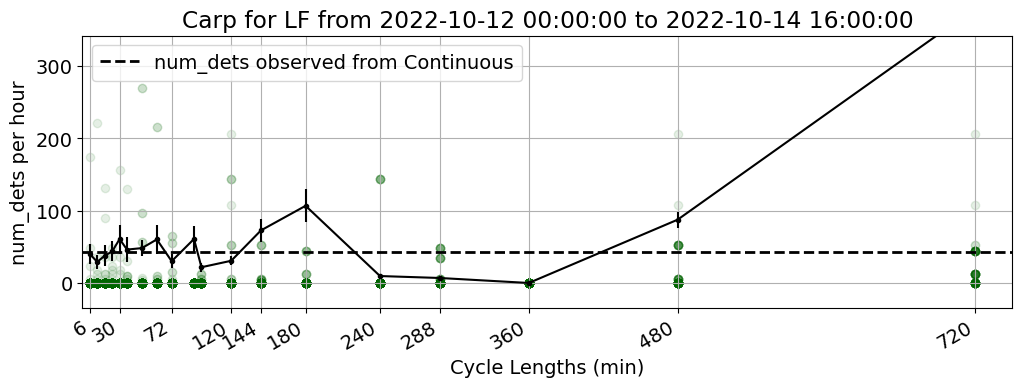

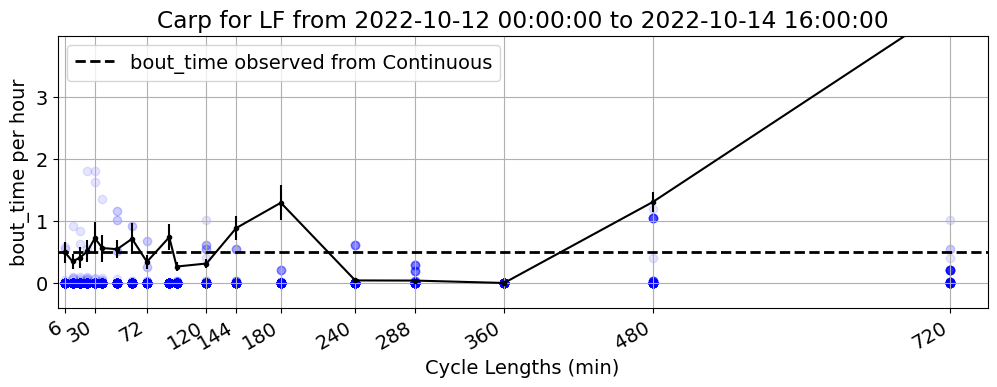

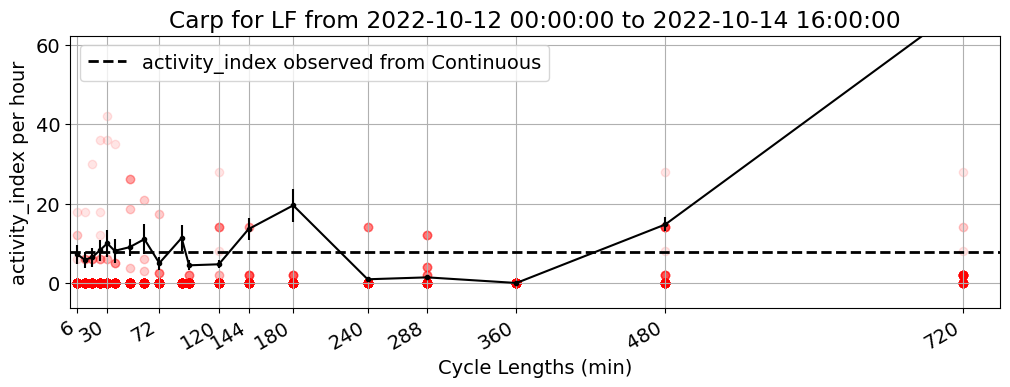

Carp HF


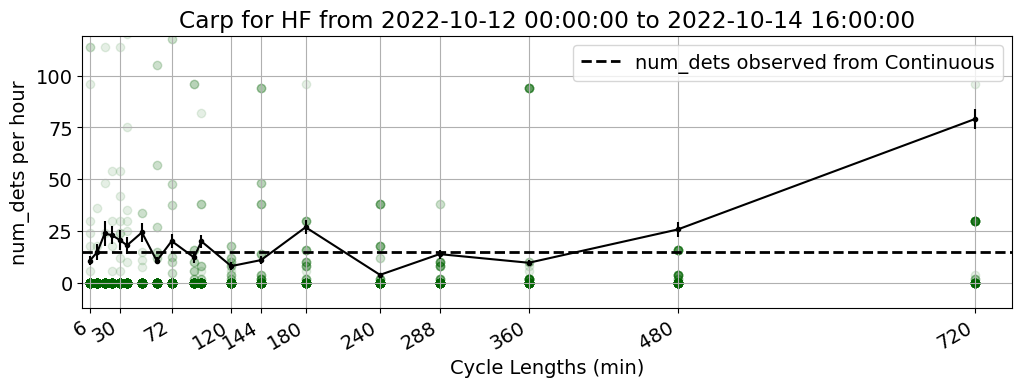

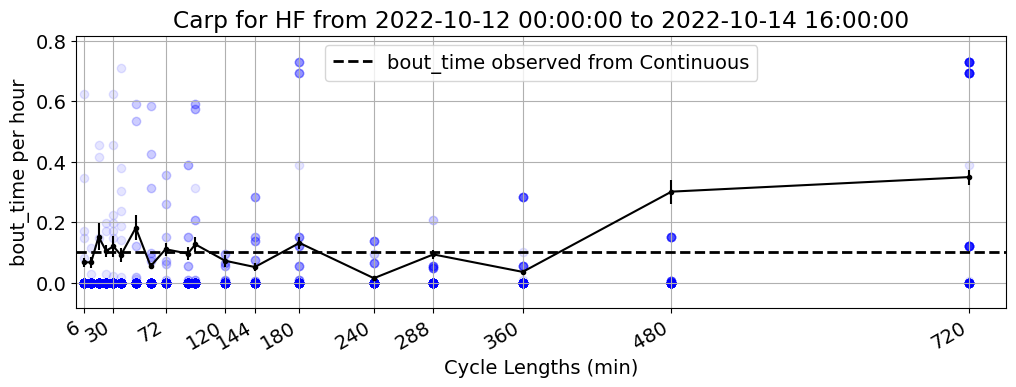

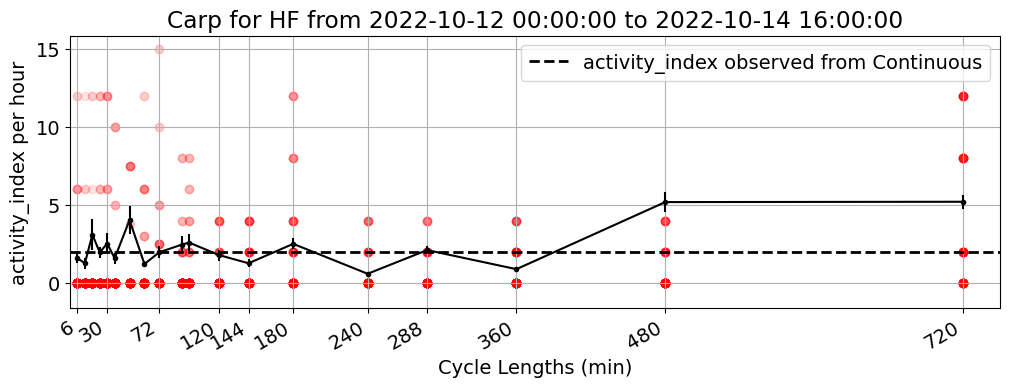

In [8]:
site_key = 'Carp'
type_keys = ['', 'LF', 'HF']
data_params['bin_size'] = '30'
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

for type_key in type_keys:
    print(site_key, type_key)
    data_params["type_tag"] = type_key

    file_paths = get_file_paths(data_params)
    data_params['metric_tag'] = 'num_dets'
    activity_dets_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_dets_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_dets_arr.index = pd.DatetimeIndex(activity_dets_arr.index)
    data_params['start'] = dt.datetime(2022, 10, 12, 0, 0, 0)
    data_params['end'] = dt.datetime(2022, 10, 14, 16, 0, 0)
    actvt_metric = activity_dets_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

    data_params['metric_tag'] = 'bout_time'
    activity_bout_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_bouts_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_bout_arr.index = pd.DatetimeIndex(activity_bout_arr.index)
    actvt_metric = activity_bout_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

    data_params['metric_tag'] = 'activity_index'
    activity_inds_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_inds_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_inds_arr.index = pd.DatetimeIndex(activity_inds_arr.index)
    actvt_metric = activity_inds_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

Telephone 


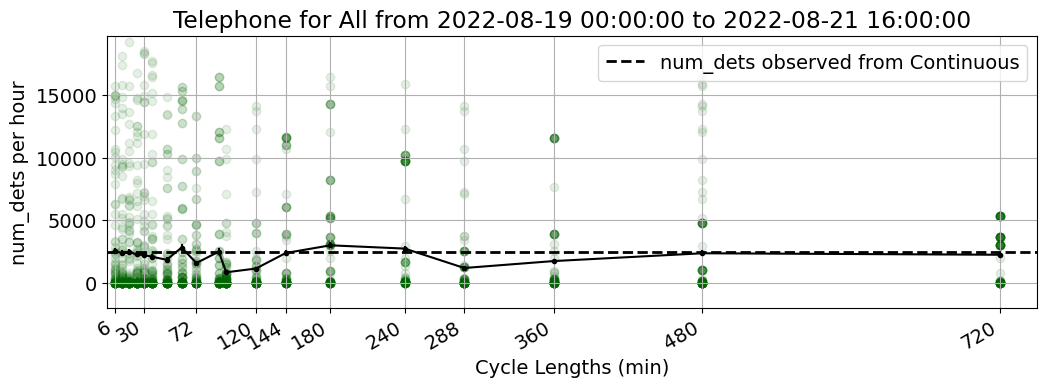

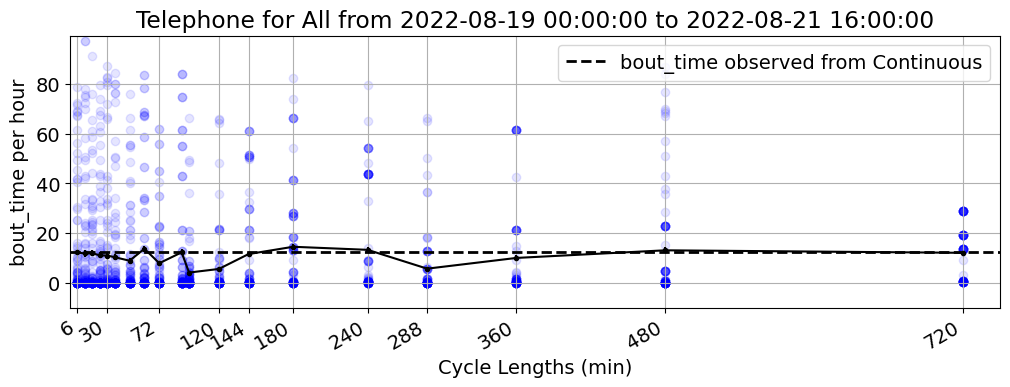

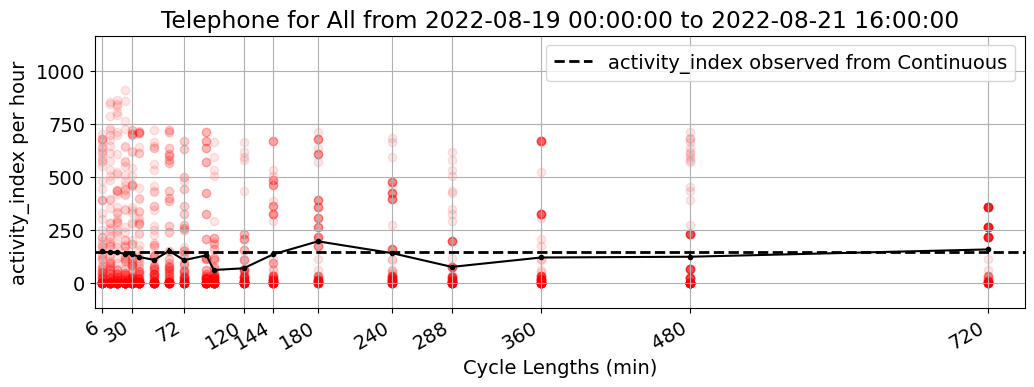

Telephone LF


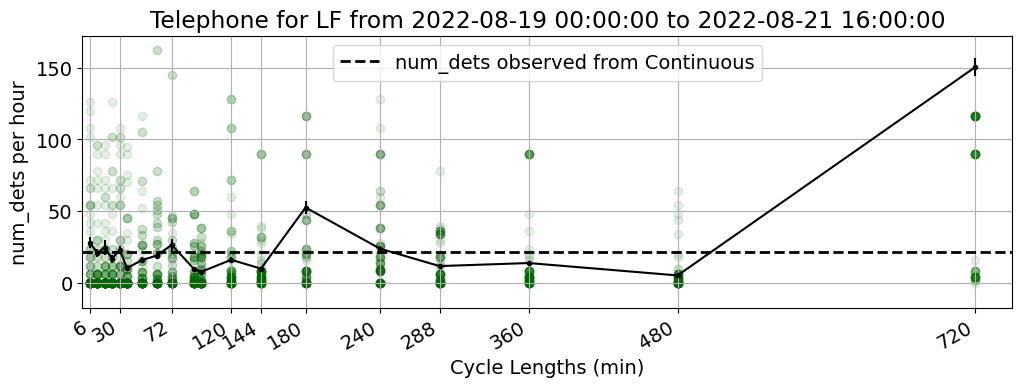

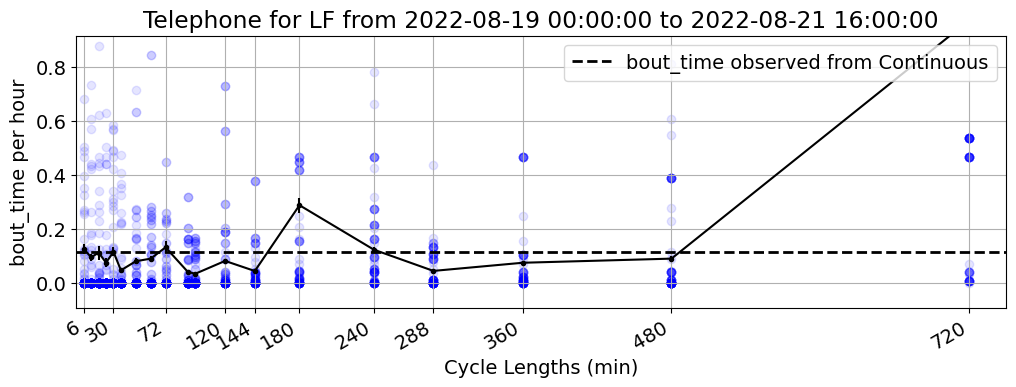

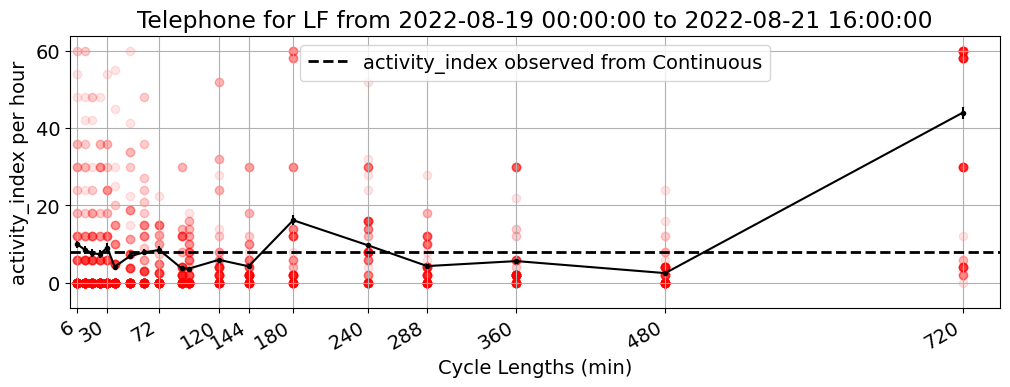

Telephone HF


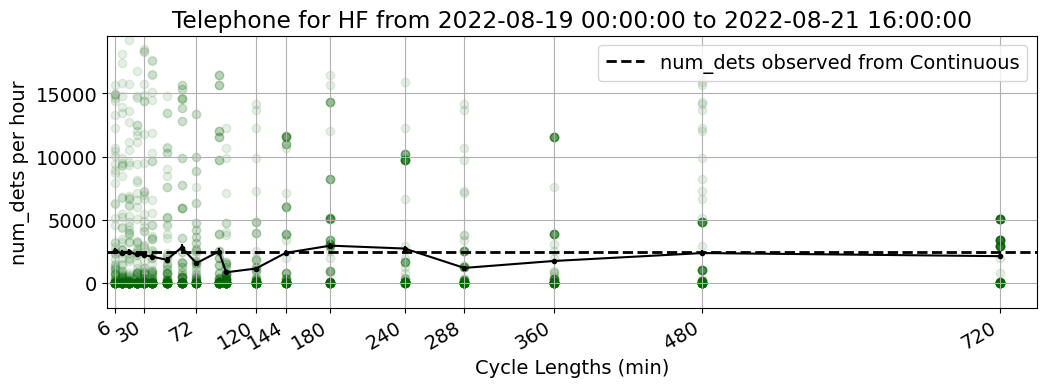

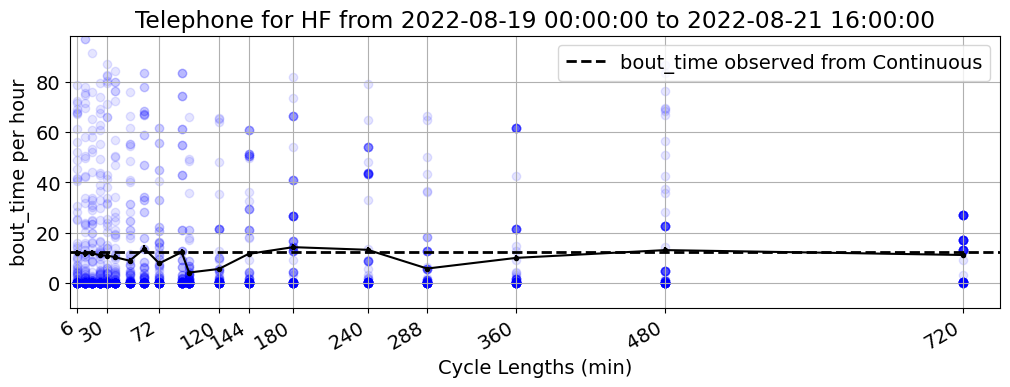

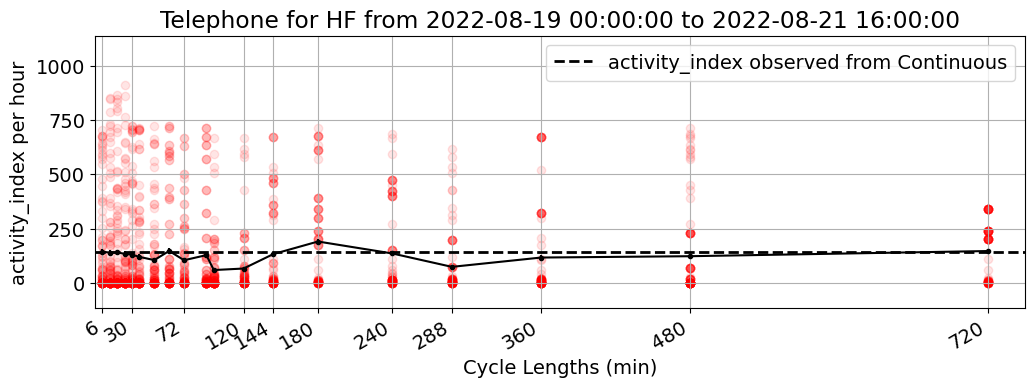

In [9]:
site_key = 'Telephone'
type_keys = ['', 'LF', 'HF']
data_params['bin_size'] = '30'
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

for type_key in type_keys:
    print(site_key, type_key)
    data_params["type_tag"] = type_key

    file_paths = get_file_paths(data_params)
    data_params['metric_tag'] = 'num_dets'
    activity_dets_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_dets_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_dets_arr.index = pd.DatetimeIndex(activity_dets_arr.index)
    data_params['start'] = dt.datetime(2022, 8, 19, 0, 0, 0)
    data_params['end'] = dt.datetime(2022, 8, 21, 16, 0, 0)
    actvt_metric = activity_dets_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

    data_params['metric_tag'] = 'bout_time'
    activity_bout_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_bouts_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_bout_arr.index = pd.DatetimeIndex(activity_bout_arr.index)
    actvt_metric = activity_bout_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

    data_params['metric_tag'] = 'activity_index'
    activity_inds_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_inds_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_inds_arr.index = pd.DatetimeIndex(activity_inds_arr.index)
    actvt_metric = activity_inds_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

Telephone 


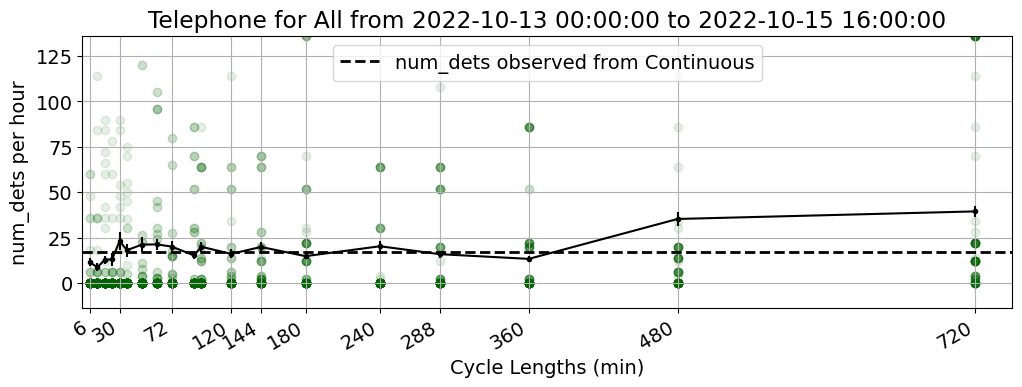

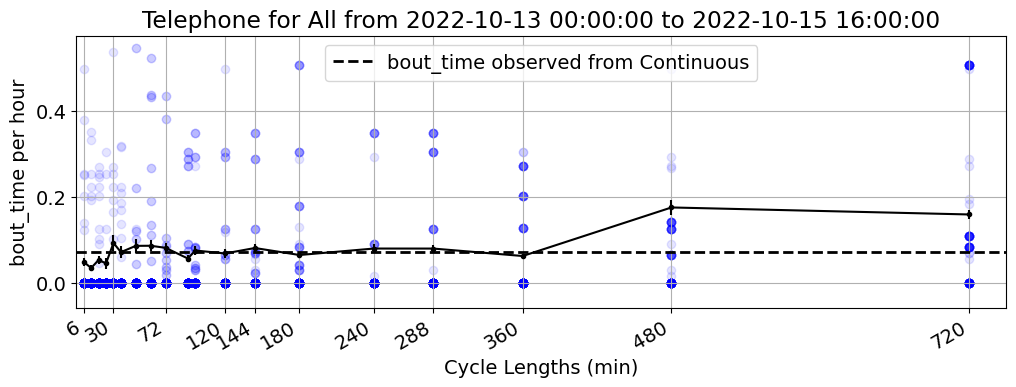

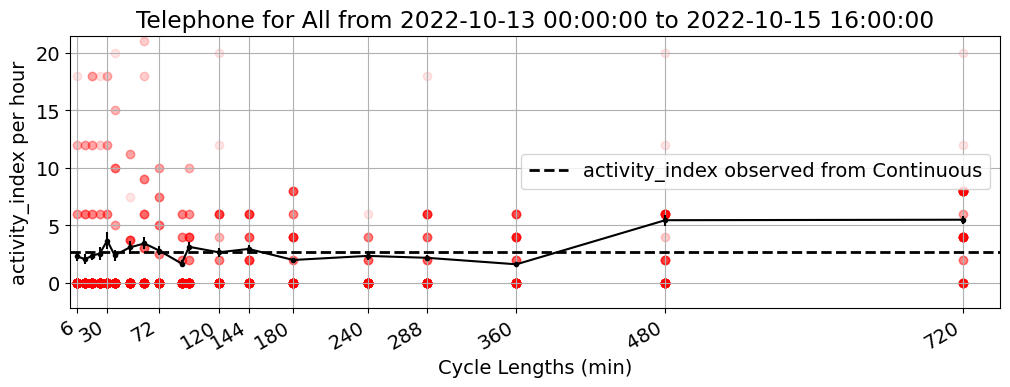

Telephone LF


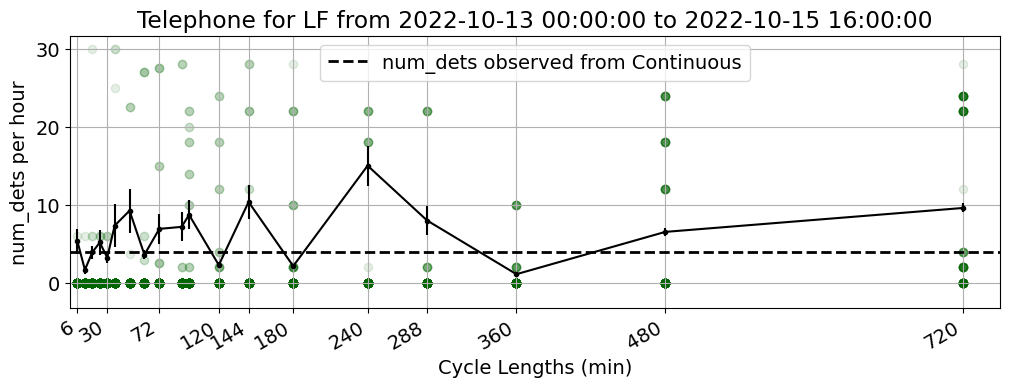

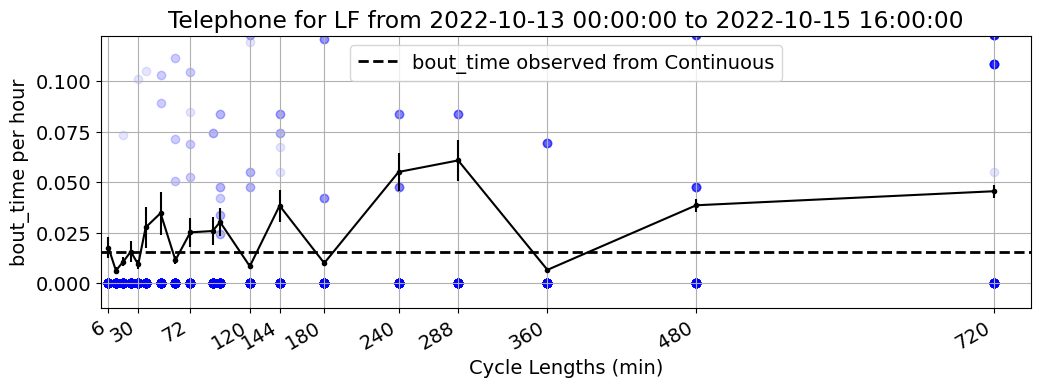

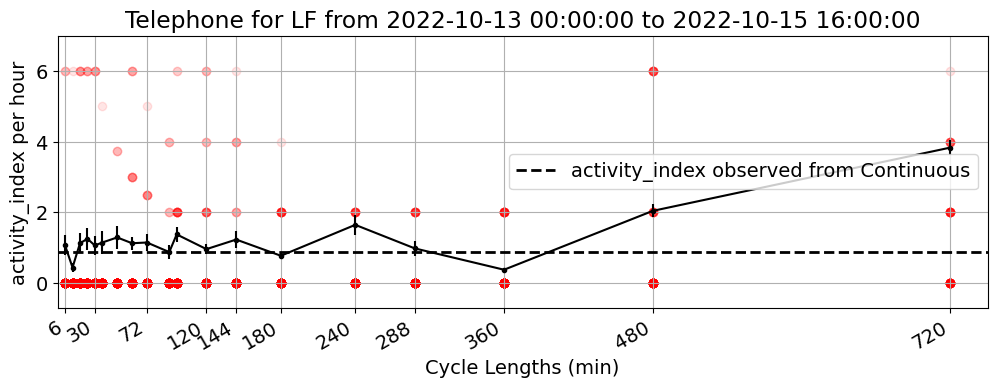

Telephone HF


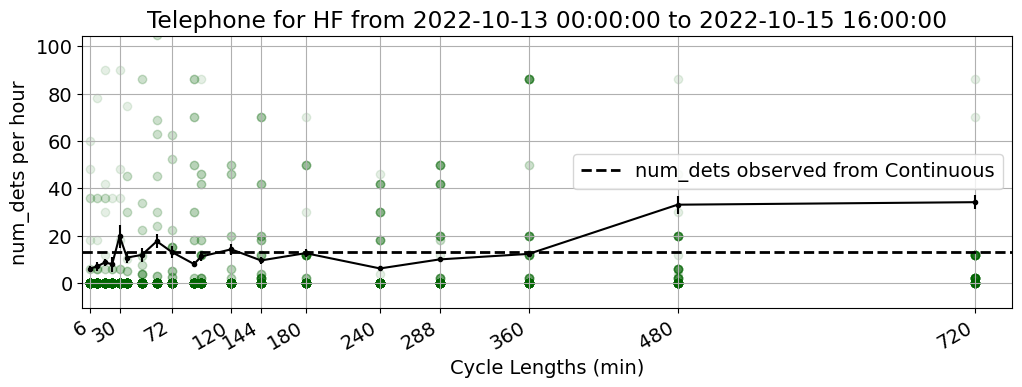

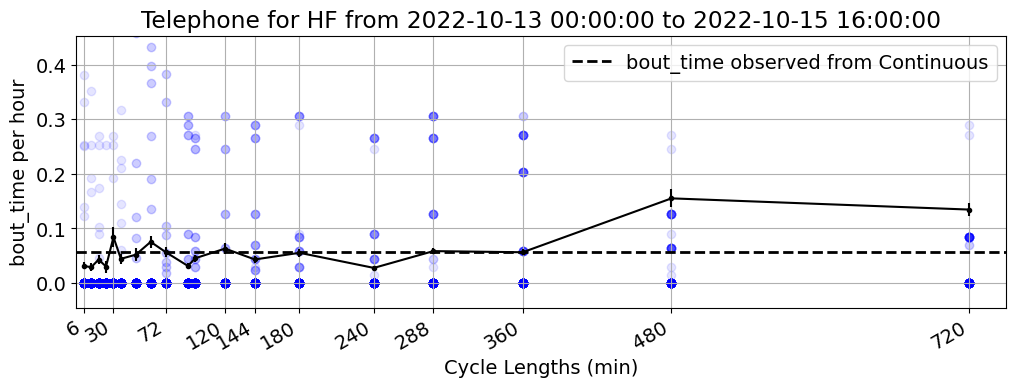

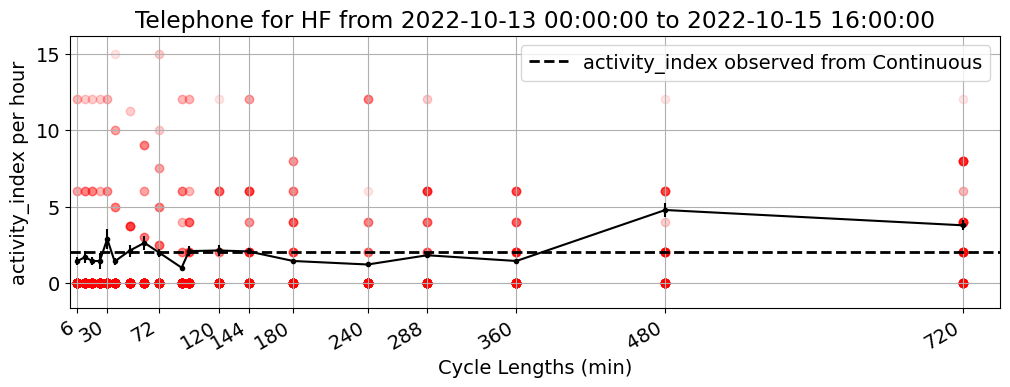

In [10]:
site_key = 'Telephone'
type_keys = ['', 'LF', 'HF']
data_params['bin_size'] = '30'
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

for type_key in type_keys:
    print(site_key, type_key)
    data_params["type_tag"] = type_key

    file_paths = get_file_paths(data_params)
    data_params['metric_tag'] = 'num_dets'
    activity_dets_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_dets_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_dets_arr.index = pd.DatetimeIndex(activity_dets_arr.index)
    data_params['start'] = dt.datetime(2022, 10, 13, 0, 0, 0)
    data_params['end'] = dt.datetime(2022, 10, 15, 16, 0, 0)
    actvt_metric = activity_dets_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

    data_params['metric_tag'] = 'bout_time'
    activity_bout_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_bouts_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_bout_arr.index = pd.DatetimeIndex(activity_bout_arr.index)
    actvt_metric = activity_bout_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)

    data_params['metric_tag'] = 'activity_index'
    activity_inds_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_inds_TYPE_SITE_summary"]}.csv', index_col=0)
    activity_inds_arr.index = pd.DatetimeIndex(activity_inds_arr.index)
    actvt_metric = activity_inds_arr.loc[data_params['start']:data_params['end']].copy()
    metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
    plot_metric_over_cycle_lengths(metrics, data_params)